In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''') 

# <font color="#E56717">IOBS & IBA Project Update</font>

# <font color="#E56717">October 2016</font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

# <font color="#E56717">First order of business is to identify all the patients in the SEER-Medicare data who have received PBT</font>

<span style="font-size:1.5em;">The relevant HCPCS codes are:</span>

* <span style="font-size:1.5em;">77520 - Proton trmt simple w/o comp</span>
* <span style="font-size:1.5em;">77522 - Proton trmt simple w/comp</span>
* <span style="font-size:1.5em;">77523 - Proton trmt intermediate</span>
* <span style="font-size:1.5em;">77525 - Proton treatment complex</span>


# <font color="#E56717">Also find all the patient who have receieved IMRT treamtment (delivery; not just planning)</font>

* <span style="font-size:1.5em;">77418 - IMRT delivery</span>

<span style="font-size:1.5em;">And then use set logic to capture only those PBT patients who did
not also receive IMRT treatment</span>

In [3]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

In [4]:
mask = (df['srvm1'] != 9999)
dfall = df[mask]

In [5]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [6]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [7]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [8]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [9]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [10]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
len(treatmentindices)

1605

In [14]:
import pickle
fileObject = open('imrt_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_outsaf = list(set.union(*b))

In [15]:
import pickle
fileObject = open('imrt_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_nch = list(set.union(*b))

In [16]:
bigcontrolindices = list(set(controlindices_nch+controlindices_outsaf))

In [17]:
bigcontrolset = set(bigcontrolindices)
allset = set(allindices)


allcontrolindices = list(allset.intersection(bigcontrolset))

controlindices = allcontrolindices
len(controlindices)

62509

In [18]:
puretreatmentindices = list(set(treatmentindices).difference(set(controlindices)))
len(puretreatmentindices)

1526

In [19]:
purecontrolindices = list(set(controlindices).difference(set(treatmentindices)))
len(purecontrolindices)

62430

# <font color="#E56717">Now use the pedsf files to perform patient matching, using the patient_id's found above</font>

<span style="font-size:1.1em;">List of pedsf files (contains SEER diagnosis year dates 2006-2011):</span>

* <span style="font-size:1.1em;">pedsf.nasopharynx.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.slivary.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.oropharynx.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.esophagus.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.brain.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.eyeandorbit.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.softtissue.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.prostate.cancer.file01.txt</span>
* <span style="font-size:1.1em;">pedsf.prostate.cancer.file02.txt</span>
* <span style="font-size:1.1em;">pedsf.prostate.cancer.file03.txt</span>
* <span style="font-size:1.1em;">pedsf.lung.cancer.file01.txt</span>
* <span style="font-size:1.1em;">pedsf.lung.cancer.flie02.txt</span>
* <span style="font-size:1.1em;">pedsf.breast.cancer.file01.txt</span>
* <span style="font-size:1.1em;">pedsf.breast.cancer.file02.txt</span>

# <font color="#E56717">The pedsf files contain one single row for each patient, and contain information for up to 10 different primary tumors</font>

<span style="font-size:1.5em;">So the prostate cancer files contain all patients with a cancer diagnosis where the primary site is the prostate for ANY of the potentially 10 different primary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.</span>

In [20]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

<span style="font-size:1.5em;">For example, in the file pedsf.salivarygland.cancer.txt, the cancer sites for the first tumor listed for each patient has the following distribution:</span>

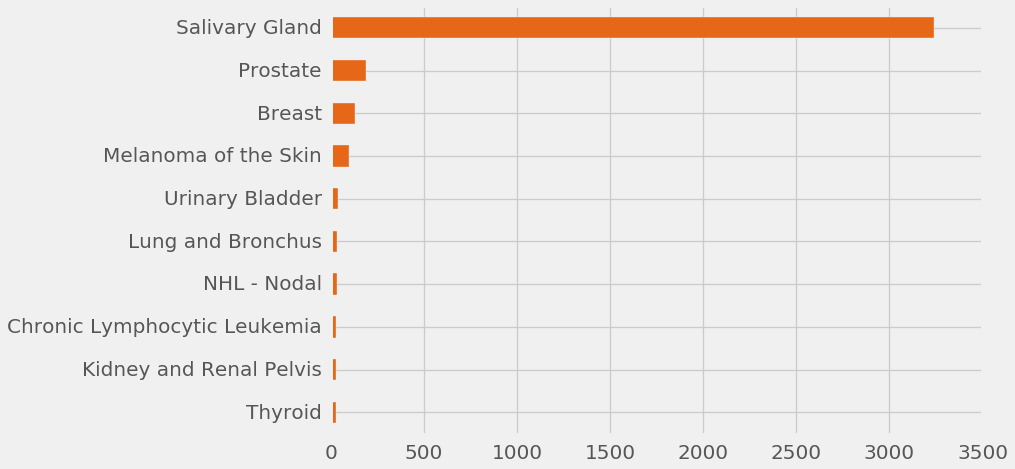

In [21]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh',
                                            color='#E56717');
plt.tick_params(labelsize=20)

# <font color="#E56717">Only keep those patients whose first tumor is at the site indicated in the corresponding file</font>

<span style="font-size:1.5em;">This way we avoid the complications other than the cancer under consideration that may be contributing factors to the outcomes we are analyzing. Also restrict the analysis to those patients who received some form of radiation treatment for this first diagnosis as indicated by the SEER data. Also, only keep those patients that SEER says received radiation (the seer radiation flag also indicates that the radiation was the first course of treament)</span>

* <span style="font-size:1.5em;">1144 PBT patients that did not receive IMRT</span>
* <span style="font-size:1.5em;">47949 IMRT patients that did not receive any PBT</span>

In [22]:
dfall.patient_id.isin(puretreatmentindices).sum()

1526

In [23]:
dfall.patient_id.isin(purecontrolindices).sum()

62430

In [24]:
dfall.shape

(719821, 496)

In [25]:
non_rad1 = dfall.rad1.str.contains('None',case=False,na=False)
refused_rad1 = dfall.rad1.str.contains('refused',case=False,na=False)
unknown_rad1 = dfall.rad1.str.contains('unknown',case=False,na=False)

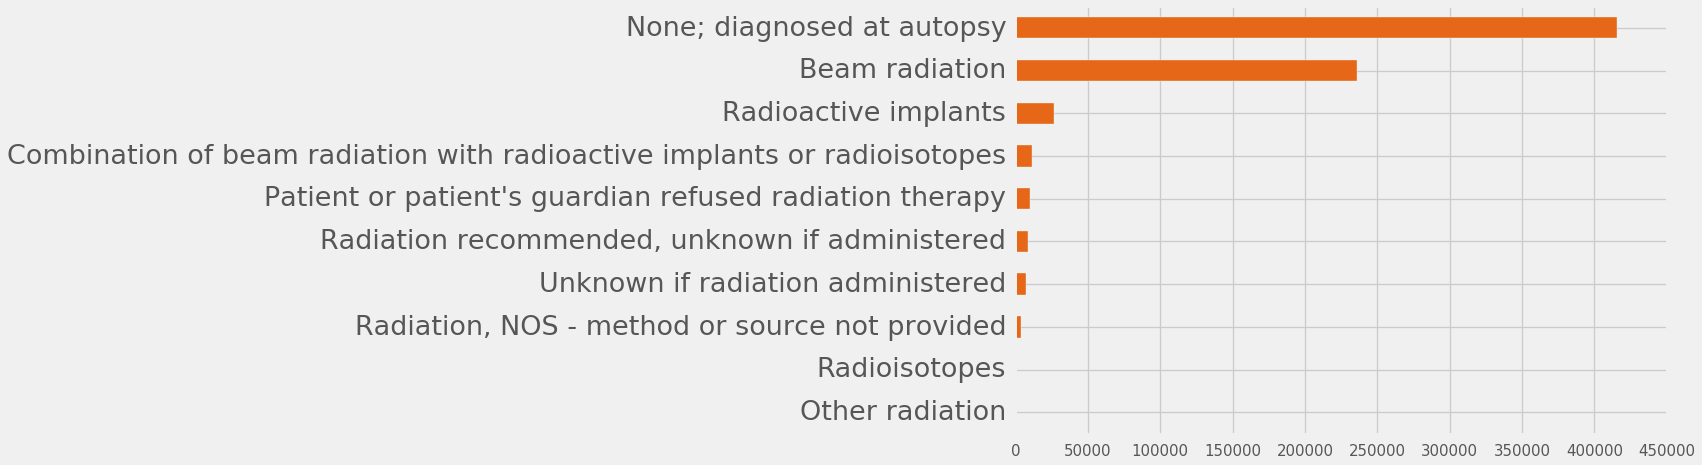

In [26]:
ax = dfall.rad1.value_counts()[::-1].plot(kind='barh',color='#E56717')
ax.yaxis.set_tick_params(labelsize=27)
ax.xaxis.set_tick_params(labelsize=15)

In [27]:
one = ~non_rad1 & ~refused_rad1 & ~unknown_rad1

had_rad = one

dfsmall = dfall[had_rad].copy()

In [28]:
dfsmall.shape

(278330, 496)

In [29]:
smalltreatmentindices = dfsmall[dfsmall.patient_id.isin(puretreatmentindices)].index
smallcontrolindices = dfsmall[dfsmall.patient_id.isin(purecontrolindices)].index

In [30]:
smallcontrolindices.shape

(47494,)

In [31]:
smalltreatmentindices.shape

(1144,)

In [32]:
set(smalltreatmentindices).issubset(puretreatmentindices) 

True

In [33]:
set(smallcontrolindices).issubset(purecontrolindices)

True

In [34]:
dfalltreatment = dfsmall.loc[smalltreatmentindices].copy()
dfallcontrol = dfsmall.loc[smallcontrolindices].copy()

In [35]:
dfalltreatment.shape, dfallcontrol.shape

((1144, 496), (47494, 496))